In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(0)   
tf.random.set_seed(0)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[85864:92469] 
Y_train_SS = Y_train_SS[85864:92469]
Y_train_V = Y_train_V[85864:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 6605
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 6605 samples, validate on 13210 samples
Epoch 1/100
6368/6605 [===========================>..] - ETA: 0s - loss: 0.1233 - dense_5_loss: 0.1028 - dense_6_loss: 0.0205 - dense_5_mse: 0.1028 - dense_6_mse: 0.0205

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.06868, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 4s 636us/sample - loss: 0.1203 - dense_5_loss: 0.1001 - dense_6_loss: 0.0200 - dense_5_mse: 0.1003 - dense_6_mse: 0.0200 - val_loss: 0.0687 - val_dense_5_loss: 0.0483 - val_dense_6_loss: 0.0204 - val_dense_5_mse: 0.0483 - val_dense_6_mse: 0.0203
Epoch 2/100
6368/6605 [===========================>..] - ETA: 0s - loss: 0.0378 - dense_5_loss: 0.0204 - dense_6_loss: 0.0175 - dense_5_mse: 0.0204 - dense_6_mse: 0.0175
Epoch 2: val_loss improved from 0.06868 to 0.06418, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 3s 391us/sample - loss: 0.0376 - dense_5_loss: 0.0201 - dense_6_loss: 0.0175 - dense_5_mse: 0.0201 - dense_6_mse: 0.0175 - val_loss: 0.0642 - val_dense_5_loss: 0.0439 - val_dense_6_loss: 0.0203 - val_dense_5_mse: 0.0439 - val_dense_6_mse: 0.0203
Epoch 3/100
6464/6605 [============================>.] - ETA: 0s - loss: 0.0286 - dense_5_loss: 0.0113 - dense_6_loss: 0.0174 - dense_5_mse: 0.0113 - dense_6_mse: 0.0174
Epoch 3: val_loss improved from 0.06418 to 0.03305, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 3s 385us/sample - loss: 0.0287 - dense_5_loss: 0.0112 - dense_6_loss: 0.0175 - dense_5_mse: 0.0112 - dense_6_mse: 0.0175 - val_loss: 0.0331 - val_dense_5_loss: 0.0127 - val_dense_6_loss: 0.0203 - val_dense_5_mse: 0.0127 - val_dense_6_mse: 0.0203
Epoch 4/100
6400/6605 [============================>.] - ETA: 0s - loss: 0.0247 - dense_5_loss: 0.0071 - dense_6_loss: 0.0176 - dense_5_mse: 0.0071 - dense_6_mse: 0.0176
Epoch 4: val_loss did not improve from 0.03305
6605/6605 [==============================] - 1s 173us/sample - loss: 0.0245 - dense_5_loss: 0.0071 - dense_6_loss: 0.0176 - dense_5_mse: 0.0071 - dense_6_mse: 0.0174 - val_loss: 0.0331 - val_dense_5_loss: 0.0128 - val_dense_6_loss: 0.0203 - val_dense_5_mse: 0.0128 - val_dense_6_mse: 0.0203
Epoch 5/100
6240/6605 [===========================>..] - ETA: 0s - loss: 0.0229 - dense_5_loss: 0.0056 - dense_6_loss: 0.0173 - dense_5_mse: 0.0056 - dense_6_mse: 0.0173
Epoch 5: val_loss did not impro

6605/6605 [==============================] - 3s 391us/sample - loss: 0.0202 - dense_5_loss: 0.0029 - dense_6_loss: 0.0173 - dense_5_mse: 0.0029 - dense_6_mse: 0.0173 - val_loss: 0.0279 - val_dense_5_loss: 0.0081 - val_dense_6_loss: 0.0198 - val_dense_5_mse: 0.0081 - val_dense_6_mse: 0.0199
Epoch 11/100
6432/6605 [============================>.] - ETA: 0s - loss: 0.0200 - dense_5_loss: 0.0027 - dense_6_loss: 0.0173 - dense_5_mse: 0.0027 - dense_6_mse: 0.0173
Epoch 11: val_loss did not improve from 0.02794
6605/6605 [==============================] - 1s 223us/sample - loss: 0.0198 - dense_5_loss: 0.0027 - dense_6_loss: 0.0171 - dense_5_mse: 0.0027 - dense_6_mse: 0.0172 - val_loss: 0.0381 - val_dense_5_loss: 0.0176 - val_dense_6_loss: 0.0205 - val_dense_5_mse: 0.0176 - val_dense_6_mse: 0.0205
Epoch 12/100
6560/6605 [============================>.] - ETA: 0s - loss: 0.0198 - dense_5_loss: 0.0026 - dense_6_loss: 0.0172 - dense_5_mse: 0.0026 - dense_6_mse: 0.0172
Epoch 12: val_loss did not i

6605/6605 [==============================] - 3s 436us/sample - loss: 0.0193 - dense_5_loss: 0.0024 - dense_6_loss: 0.0169 - dense_5_mse: 0.0023 - dense_6_mse: 0.0170 - val_loss: 0.0266 - val_dense_5_loss: 0.0069 - val_dense_6_loss: 0.0197 - val_dense_5_mse: 0.0069 - val_dense_6_mse: 0.0197
Epoch 15/100
6304/6605 [===========================>..] - ETA: 0s - loss: 0.0179 - dense_5_loss: 0.0023 - dense_6_loss: 0.0156 - dense_5_mse: 0.0023 - dense_6_mse: 0.0156
Epoch 15: val_loss did not improve from 0.02660
6605/6605 [==============================] - 1s 173us/sample - loss: 0.0179 - dense_5_loss: 0.0023 - dense_6_loss: 0.0157 - dense_5_mse: 0.0023 - dense_6_mse: 0.0156 - val_loss: 0.0290 - val_dense_5_loss: 0.0136 - val_dense_6_loss: 0.0155 - val_dense_5_mse: 0.0136 - val_dense_6_mse: 0.0155
Epoch 16/100
6272/6605 [===========================>..] - ETA: 0s - loss: 0.0144 - dense_5_loss: 0.0033 - dense_6_loss: 0.0111 - dense_5_mse: 0.0033 - dense_6_mse: 0.0111
Epoch 16: val_loss improved 

6605/6605 [==============================] - 3s 400us/sample - loss: 0.0142 - dense_5_loss: 0.0033 - dense_6_loss: 0.0110 - dense_5_mse: 0.0033 - dense_6_mse: 0.0110 - val_loss: 0.0198 - val_dense_5_loss: 0.0082 - val_dense_6_loss: 0.0116 - val_dense_5_mse: 0.0082 - val_dense_6_mse: 0.0116
Epoch 17/100
6048/6605 [==========================>...] - ETA: 0s - loss: 0.0102 - dense_5_loss: 0.0028 - dense_6_loss: 0.0074 - dense_5_mse: 0.0028 - dense_6_mse: 0.0074
Epoch 17: val_loss did not improve from 0.01978
6605/6605 [==============================] - 1s 162us/sample - loss: 0.0104 - dense_5_loss: 0.0030 - dense_6_loss: 0.0074 - dense_5_mse: 0.0030 - dense_6_mse: 0.0074 - val_loss: 0.0312 - val_dense_5_loss: 0.0257 - val_dense_6_loss: 0.0055 - val_dense_5_mse: 0.0257 - val_dense_6_mse: 0.0055
Epoch 18/100
6208/6605 [===========================>..] - ETA: 0s - loss: 0.0063 - dense_5_loss: 0.0027 - dense_6_loss: 0.0037 - dense_5_mse: 0.0027 - dense_6_mse: 0.0037
Epoch 18: val_loss improved 

6605/6605 [==============================] - 3s 402us/sample - loss: 0.0065 - dense_5_loss: 0.0027 - dense_6_loss: 0.0038 - dense_5_mse: 0.0027 - dense_6_mse: 0.0038 - val_loss: 0.0108 - val_dense_5_loss: 0.0051 - val_dense_6_loss: 0.0058 - val_dense_5_mse: 0.0051 - val_dense_6_mse: 0.0058
Epoch 19/100
6080/6605 [==========================>...] - ETA: 0s - loss: 0.0062 - dense_5_loss: 0.0026 - dense_6_loss: 0.0036 - dense_5_mse: 0.0026 - dense_6_mse: 0.0036
Epoch 19: val_loss did not improve from 0.01081
6605/6605 [==============================] - 1s 171us/sample - loss: 0.0068 - dense_5_loss: 0.0027 - dense_6_loss: 0.0041 - dense_5_mse: 0.0027 - dense_6_mse: 0.0041 - val_loss: 0.0195 - val_dense_5_loss: 0.0053 - val_dense_6_loss: 0.0143 - val_dense_5_mse: 0.0053 - val_dense_6_mse: 0.0142
Epoch 20/100
6605/6605 [==============================] - ETA: 0s - loss: 0.0067 - dense_5_loss: 0.0024 - dense_6_loss: 0.0044 - dense_5_mse: 0.0024 - dense_6_mse: 0.0044
Epoch 20: val_loss did not i

6605/6605 [==============================] - 3s 385us/sample - loss: 0.0054 - dense_5_loss: 0.0019 - dense_6_loss: 0.0035 - dense_5_mse: 0.0019 - dense_6_mse: 0.0035 - val_loss: 0.0089 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 0.0060 - val_dense_5_mse: 0.0029 - val_dense_6_mse: 0.0060
Epoch 31/100
6240/6605 [===========================>..] - ETA: 0s - loss: 0.0041 - dense_5_loss: 0.0016 - dense_6_loss: 0.0025 - dense_5_mse: 0.0016 - dense_6_mse: 0.0025
Epoch 31: val_loss improved from 0.00890 to 0.00730, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 3s 386us/sample - loss: 0.0042 - dense_5_loss: 0.0016 - dense_6_loss: 0.0027 - dense_5_mse: 0.0016 - dense_6_mse: 0.0026 - val_loss: 0.0073 - val_dense_5_loss: 0.0037 - val_dense_6_loss: 0.0036 - val_dense_5_mse: 0.0037 - val_dense_6_mse: 0.0036
Epoch 32/100
6208/6605 [===========================>..] - ETA: 0s - loss: 0.0034 - dense_5_loss: 0.0014 - dense_6_loss: 0.0020 - dense_5_mse: 0.0014 - dense_6_mse: 0.0020
Epoch 32: val_loss did not improve from 0.00730
6605/6605 [==============================] - 1s 169us/sample - loss: 0.0036 - dense_5_loss: 0.0015 - dense_6_loss: 0.0022 - dense_5_mse: 0.0015 - dense_6_mse: 0.0022 - val_loss: 0.0079 - val_dense_5_loss: 0.0043 - val_dense_6_loss: 0.0036 - val_dense_5_mse: 0.0043 - val_dense_6_mse: 0.0037
Epoch 33/100
6432/6605 [============================>.] - ETA: 0s - loss: 0.0035 - dense_5_loss: 0.0015 - dense_6_loss: 0.0020 - dense_5_mse: 0.0015 - dense_6_mse: 0.0020
Epoch 33: val_loss did not i

6605/6605 [==============================] - 3s 433us/sample - loss: 0.0028 - dense_5_loss: 0.0012 - dense_6_loss: 0.0016 - dense_5_mse: 0.0012 - dense_6_mse: 0.0016 - val_loss: 0.0073 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 0.0041 - val_dense_5_mse: 0.0032 - val_dense_6_mse: 0.0041
Epoch 38/100
6605/6605 [==============================] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016
Epoch 38: val_loss improved from 0.00725 to 0.00581, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 3s 399us/sample - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016 - val_loss: 0.0058 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 0.0029 - val_dense_5_mse: 0.0030 - val_dense_6_mse: 0.0029
Epoch 39/100
6464/6605 [============================>.] - ETA: 0s - loss: 0.0026 - dense_5_loss: 0.0012 - dense_6_loss: 0.0015 - dense_5_mse: 0.0012 - dense_6_mse: 0.0015
Epoch 39: val_loss did not improve from 0.00581
6605/6605 [==============================] - 1s 168us/sample - loss: 0.0026 - dense_5_loss: 0.0012 - dense_6_loss: 0.0015 - dense_5_mse: 0.0012 - dense_6_mse: 0.0015 - val_loss: 0.0072 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 0.0037 - val_dense_5_mse: 0.0035 - val_dense_6_mse: 0.0037
Epoch 40/100
6592/6605 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0012 - dense_6_loss: 0.0015 - dense_5_mse: 0.0012 - dense_6_mse: 0.0015
Epoch 40: val_loss did not i

6605/6605 [==============================] - 3s 391us/sample - loss: 0.0028 - dense_5_loss: 0.0012 - dense_6_loss: 0.0016 - dense_5_mse: 0.0012 - dense_6_mse: 0.0016 - val_loss: 0.0055 - val_dense_5_loss: 0.0025 - val_dense_6_loss: 0.0030 - val_dense_5_mse: 0.0025 - val_dense_6_mse: 0.0030
Epoch 44/100
6605/6605 [==============================] - ETA: 0s - loss: 0.0025 - dense_5_loss: 9.9607e-04 - dense_6_loss: 0.0015 - dense_5_mse: 9.9128e-04 - dense_6_mse: 0.0015
Epoch 44: val_loss did not improve from 0.00553
6605/6605 [==============================] - 1s 182us/sample - loss: 0.0025 - dense_5_loss: 9.9607e-04 - dense_6_loss: 0.0015 - dense_5_mse: 9.9128e-04 - dense_6_mse: 0.0015 - val_loss: 0.0075 - val_dense_5_loss: 0.0051 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0051 - val_dense_6_mse: 0.0024
Epoch 45/100
6336/6605 [===========================>..] - ETA: 0s - loss: 0.0025 - dense_5_loss: 0.0011 - dense_6_loss: 0.0014 - dense_5_mse: 0.0011 - dense_6_mse: 0.0014
Epoch 45: va

6605/6605 [==============================] - 3s 417us/sample - loss: 0.0026 - dense_5_loss: 9.5253e-04 - dense_6_loss: 0.0016 - dense_5_mse: 9.5423e-04 - dense_6_mse: 0.0016 - val_loss: 0.0052 - val_dense_5_loss: 0.0028 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0028 - val_dense_6_mse: 0.0024
Epoch 53/100
6560/6605 [============================>.] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0012 - dense_6_loss: 0.0017 - dense_5_mse: 0.0012 - dense_6_mse: 0.0017
Epoch 53: val_loss did not improve from 0.00518
6605/6605 [==============================] - 1s 176us/sample - loss: 0.0028 - dense_5_loss: 0.0012 - dense_6_loss: 0.0016 - dense_5_mse: 0.0012 - dense_6_mse: 0.0016 - val_loss: 0.0093 - val_dense_5_loss: 0.0045 - val_dense_6_loss: 0.0048 - val_dense_5_mse: 0.0045 - val_dense_6_mse: 0.0048
Epoch 54/100
6272/6605 [===========================>..] - ETA: 0s - loss: 0.0024 - dense_5_loss: 0.0010 - dense_6_loss: 0.0014 - dense_5_mse: 0.0010 - dense_6_mse: 0.0014
Epoch 54: val_loss d

6605/6605 [==============================] - 3s 410us/sample - loss: 0.0025 - dense_5_loss: 0.0010 - dense_6_loss: 0.0015 - dense_5_mse: 0.0010 - dense_6_mse: 0.0015 - val_loss: 0.0051 - val_dense_5_loss: 0.0026 - val_dense_6_loss: 0.0025 - val_dense_5_mse: 0.0026 - val_dense_6_mse: 0.0025
Epoch 56/100
6144/6605 [==========================>...] - ETA: 0s - loss: 0.0023 - dense_5_loss: 9.5069e-04 - dense_6_loss: 0.0014 - dense_5_mse: 9.5069e-04 - dense_6_mse: 0.0014
Epoch 56: val_loss did not improve from 0.00512
6605/6605 [==============================] - 1s 173us/sample - loss: 0.0023 - dense_5_loss: 9.2229e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.2363e-04 - dense_6_mse: 0.0013 - val_loss: 0.0051 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 0.0022 - val_dense_5_mse: 0.0029 - val_dense_6_mse: 0.0022
Epoch 57/100
6464/6605 [============================>.] - ETA: 0s - loss: 0.0021 - dense_5_loss: 8.1758e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.1758e-04 - dense_6_mse: 0.0013
Epoc

6605/6605 [==============================] - 3s 436us/sample - loss: 0.0021 - dense_5_loss: 8.6145e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.6277e-04 - dense_6_mse: 0.0012 - val_loss: 0.0050 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0029 - val_dense_6_mse: 0.0021
Epoch 62/100
6400/6605 [============================>.] - ETA: 0s - loss: 0.0026 - dense_5_loss: 0.0010 - dense_6_loss: 0.0015 - dense_5_mse: 0.0010 - dense_6_mse: 0.0015        
Epoch 62: val_loss did not improve from 0.00504
6605/6605 [==============================] - 1s 173us/sample - loss: 0.0025 - dense_5_loss: 0.0010 - dense_6_loss: 0.0015 - dense_5_mse: 0.0010 - dense_6_mse: 0.0015 - val_loss: 0.0052 - val_dense_5_loss: 0.0027 - val_dense_6_loss: 0.0025 - val_dense_5_mse: 0.0027 - val_dense_6_mse: 0.0025
Epoch 63/100
6144/6605 [==========================>...] - ETA: 0s - loss: 0.0020 - dense_5_loss: 7.8815e-04 - dense_6_loss: 0.0012 - dense_5_mse: 7.8815e-04 - dense_6_mse: 0.0012
Epoc

6605/6605 [==============================] - 3s 410us/sample - loss: 0.0018 - dense_5_loss: 7.2812e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.2563e-04 - dense_6_mse: 0.0010 - val_loss: 0.0048 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0029 - val_dense_6_mse: 0.0019
Epoch 67/100
6528/6605 [============================>.] - ETA: 0s - loss: 0.0024 - dense_5_loss: 9.7947e-04 - dense_6_loss: 0.0015 - dense_5_mse: 9.7947e-04 - dense_6_mse: 0.0015
Epoch 67: val_loss did not improve from 0.00480
6605/6605 [==============================] - 1s 171us/sample - loss: 0.0025 - dense_5_loss: 9.9113e-04 - dense_6_loss: 0.0015 - dense_5_mse: 9.8997e-04 - dense_6_mse: 0.0015 - val_loss: 0.0056 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0034 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0034
Epoch 68/100
6208/6605 [===========================>..] - ETA: 0s - loss: 0.0037 - dense_5_loss: 0.0014 - dense_6_loss: 0.0024 - dense_5_mse: 0.0014 - dense_6_mse: 0.0024
Epoc

6605/6605 [==============================] - 3s 406us/sample - loss: 0.0021 - dense_5_loss: 8.1810e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.1863e-04 - dense_6_mse: 0.0013 - val_loss: 0.0048 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0027 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0027
Epoch 73/100
6400/6605 [============================>.] - ETA: 0s - loss: 0.0018 - dense_5_loss: 7.9202e-04 - dense_6_loss: 9.6736e-04 - dense_5_mse: 7.9202e-04 - dense_6_mse: 9.6736e-04
Epoch 73: val_loss did not improve from 0.00476
6605/6605 [==============================] - 1s 175us/sample - loss: 0.0017 - dense_5_loss: 7.9287e-04 - dense_6_loss: 9.5260e-04 - dense_5_mse: 7.9184e-04 - dense_6_mse: 9.5523e-04 - val_loss: 0.0049 - val_dense_5_loss: 0.0024 - val_dense_6_loss: 0.0025 - val_dense_5_mse: 0.0024 - val_dense_6_mse: 0.0025
Epoch 74/100
6336/6605 [===========================>..] - ETA: 0s - loss: 0.0018 - dense_5_loss: 8.1766e-04 - dense_6_loss: 9.6617e-04 - dense_5_mse: 8.1766e-0

6605/6605 [==============================] - 3s 387us/sample - loss: 0.0022 - dense_5_loss: 8.0720e-04 - dense_6_loss: 0.0014 - dense_5_mse: 8.0639e-04 - dense_6_mse: 0.0014 - val_loss: 0.0042 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0020
Epoch 79/100
6176/6605 [===========================>..] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0010 - dense_6_loss: 0.0017 - dense_5_mse: 0.0010 - dense_6_mse: 0.0017
Epoch 79: val_loss did not improve from 0.00419
6605/6605 [==============================] - 1s 165us/sample - loss: 0.0026 - dense_5_loss: 9.5949e-04 - dense_6_loss: 0.0016 - dense_5_mse: 9.6185e-04 - dense_6_mse: 0.0016 - val_loss: 0.0070 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 0.0036 - val_dense_5_mse: 0.0034 - val_dense_6_mse: 0.0036
Epoch 80/100
6336/6605 [===========================>..] - ETA: 0s - loss: 0.0020 - dense_5_loss: 8.0146e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.0146e-04 - dense_6_mse: 0.0012
Epoc

6605/6605 [==============================] - 3s 394us/sample - loss: 0.0027 - dense_5_loss: 7.6110e-04 - dense_6_loss: 0.0020 - dense_5_mse: 7.5752e-04 - dense_6_mse: 0.0019 - val_loss: 0.0040 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0020
Epoch 96/100
6528/6605 [============================>.] - ETA: 0s - loss: 0.0016 - dense_5_loss: 6.7568e-04 - dense_6_loss: 9.4392e-04 - dense_5_mse: 6.7568e-04 - dense_6_mse: 9.4392e-04
Epoch 96: val_loss improved from 0.00403 to 0.00356, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


6605/6605 [==============================] - 3s 436us/sample - loss: 0.0016 - dense_5_loss: 6.7219e-04 - dense_6_loss: 9.4681e-04 - dense_5_mse: 6.7293e-04 - dense_6_mse: 9.4945e-04 - val_loss: 0.0036 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0017
Epoch 97/100
6112/6605 [==========================>...] - ETA: 0s - loss: 0.0013 - dense_5_loss: 4.6919e-04 - dense_6_loss: 8.4701e-04 - dense_5_mse: 4.6919e-04 - dense_6_mse: 8.4701e-04
Epoch 97: val_loss did not improve from 0.00356
6605/6605 [==============================] - 1s 167us/sample - loss: 0.0013 - dense_5_loss: 4.8585e-04 - dense_6_loss: 8.3790e-04 - dense_5_mse: 4.8661e-04 - dense_6_mse: 8.4023e-04 - val_loss: 0.0059 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 0.0025 - val_dense_5_mse: 0.0034 - val_dense_6_mse: 0.0025
Epoch 98/100
6208/6605 [===========================>..] - ETA: 0s - loss: 0.0017 - dense_5_loss: 7.0571e-04 - dense_6_loss: 9.9862e-04 - dense_5_mse: 7

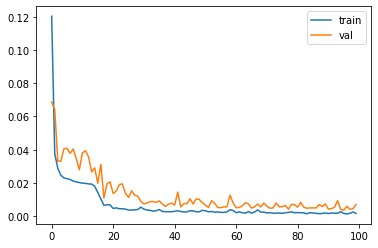

---Training time: 149.92990351 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.97907, Train (V) - 0.92457
R2 scores: Validation (SS) - 0.95919, Validation (V) - 0.85035
R2 scores: Testing (SS) - 0.72903, Testing (V) - 0.78581
RMSE scores: Train (SS) - 0.03218, Train (V) - 0.03621
RMSE scores: Validation (SS) - 0.04730, Validation (V) - 0.05509
RMSE scores: Testing (SS) - 0.11942, Testing (V) - 0.06403


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

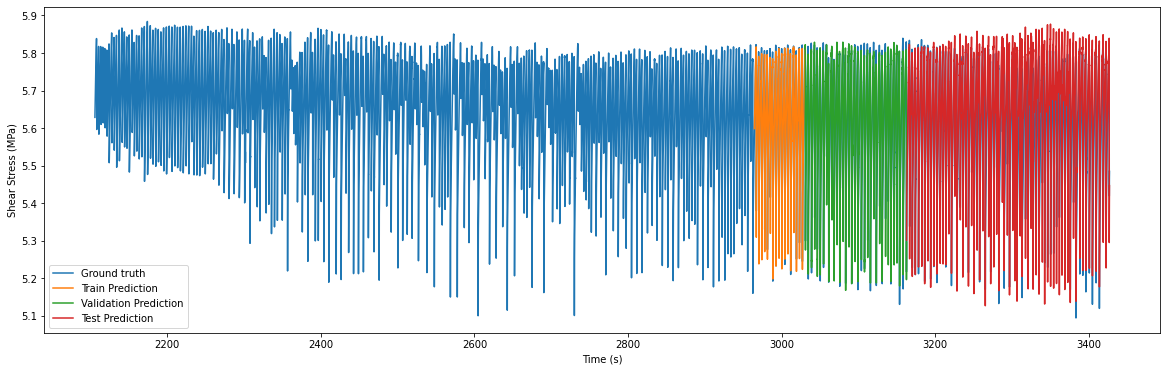

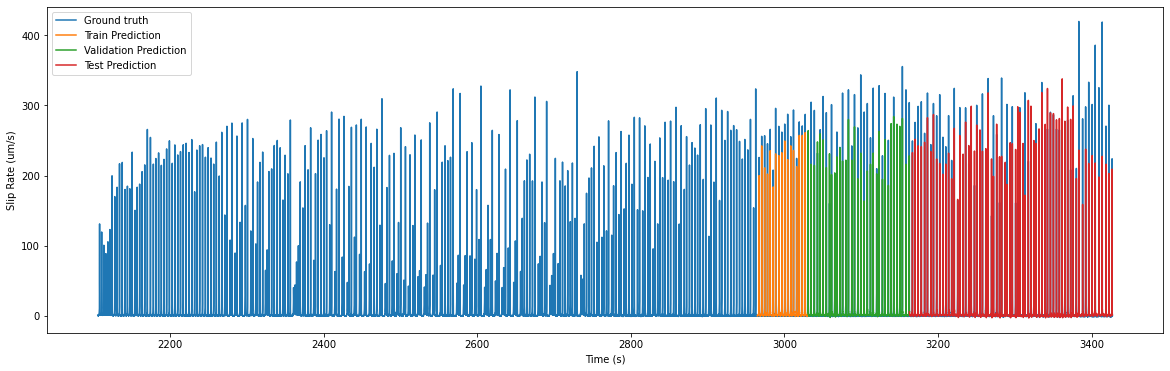

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[85864:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

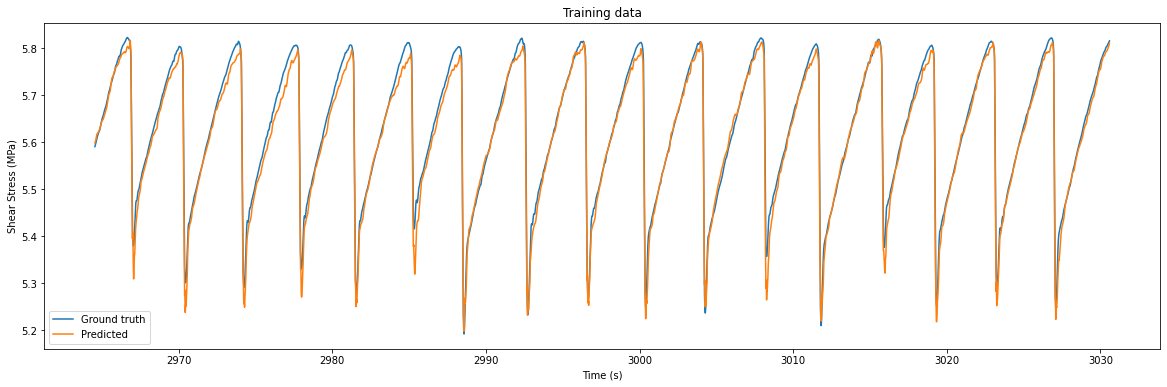

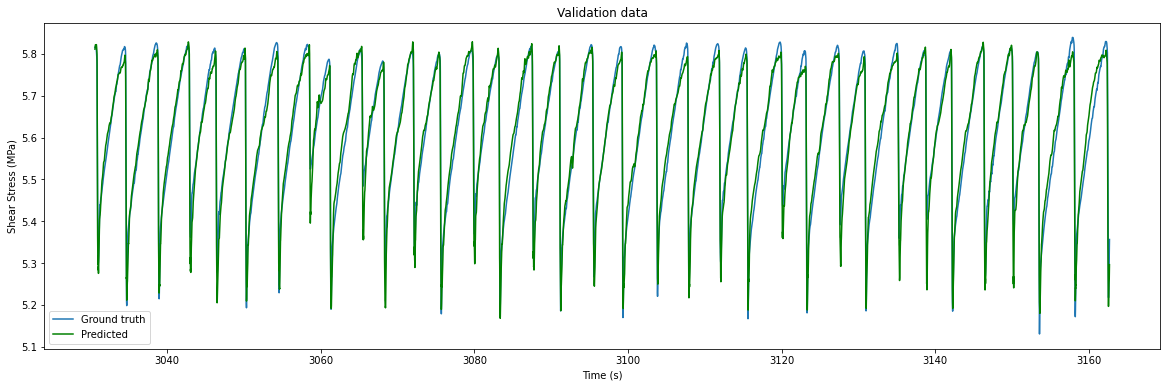

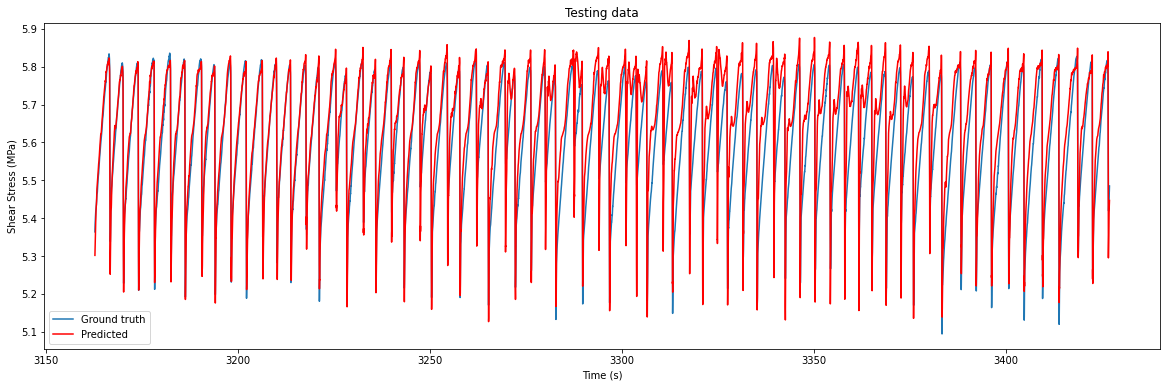

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

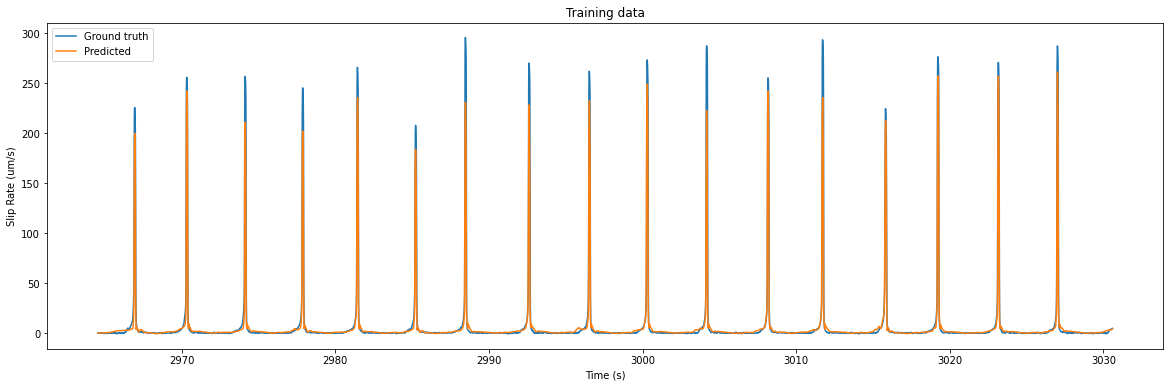

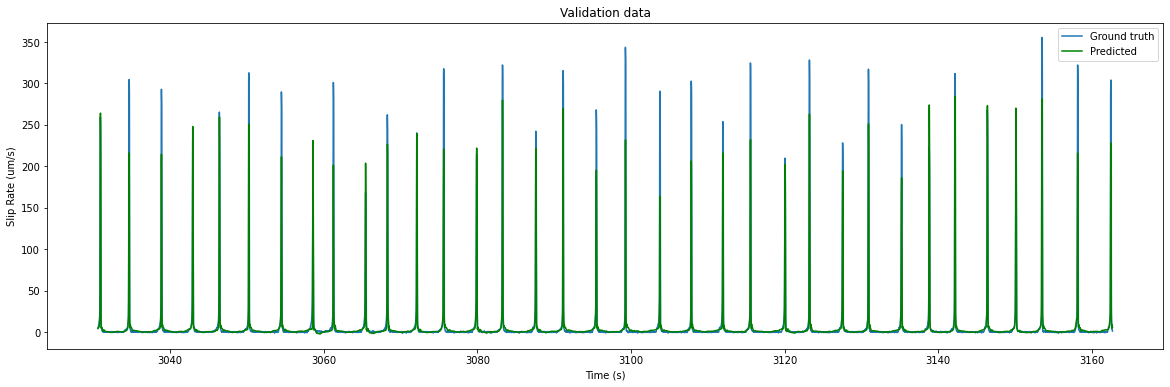

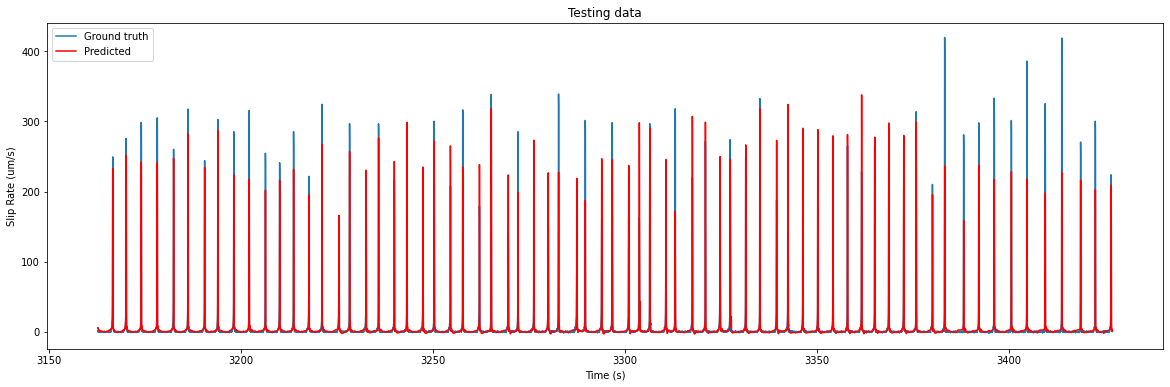

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')